# TalkingData AdTracking Fraud Detection Challenge

Can you detect fraudulent click traffic for mobile app ads?

In [1]:
# #Python Libraries
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels
import pandas_profiling

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import os
import sys
import time
import requests
import datetime

import missingno as msno
import gc

# from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
# #X_trainval, X_test, y_trainval, y_test = train_test_split(X, y)
# #X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval)
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn.cross_validation import train_test_split
import xgboost as xgb

c:\users\karti\appdata\local\programs\python\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Data and Data Dictionary

In [2]:
!ls data

sample_submission.csv
test.csv
train.csv
train_reduced.csv
train_sample.csv


## File descriptions

`train.csv` - the training set

`train_sample.csv` - 100,000 randomly-selected rows of training data, to inspect data before downloading full set

`test.csv` - the test set

`sampleSubmission.csv` - a sample submission file in the correct format

## Data fields
Each row of the training data contains a click record, with the following features.

`ip`: ip address of click.

`app`: app id for marketing.

`device`: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)

`os`: os version id of user mobile phone

`channel`: channel id of mobile ad publisher

`click_time`: timestamp of click (UTC)

`attributed_time`: if user download the app for after clicking an ad, this is the time of the app download

`is_attributed`: the target that is to be predicted, indicating the app was downloaded

Note that ip, app, device, os, and channel are encoded.

The test data is similar, with the following differences:

`click_id`: reference for making predictions

`is_attributed`: not included

In [3]:
df_train = pd.read_csv("data/train_sample.csv")

In [4]:
df_train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,87540,12,1,13,497,2017-11-07 09:30:38,NaN,0
1,105560,25,1,17,259,2017-11-07 13:40:27,NaN,0
2,101424,12,1,19,212,2017-11-07 18:05:24,NaN,0
3,94584,13,1,13,477,2017-11-07 04:58:08,NaN,0
4,68413,12,1,1,178,2017-11-09 09:00:09,NaN,0


In [5]:
df_train.shape

(100000, 8)

In [6]:
!head data/test.csv

click_id,ip,app,device,os,channel,click_time
0,5744,9,1,3,107,2017-11-10 04:00:00
1,119901,9,1,3,466,2017-11-10 04:00:00
2,72287,21,1,19,128,2017-11-10 04:00:00
3,78477,15,1,13,111,2017-11-10 04:00:00
4,123080,12,1,13,328,2017-11-10 04:00:00
5,110769,18,1,13,107,2017-11-10 04:00:00
6,12540,3,1,1,137,2017-11-10 04:00:00
7,88637,27,1,19,153,2017-11-10 04:00:00
9,14932,18,1,10,107,2017-11-10 04:00:00


# Missing Data

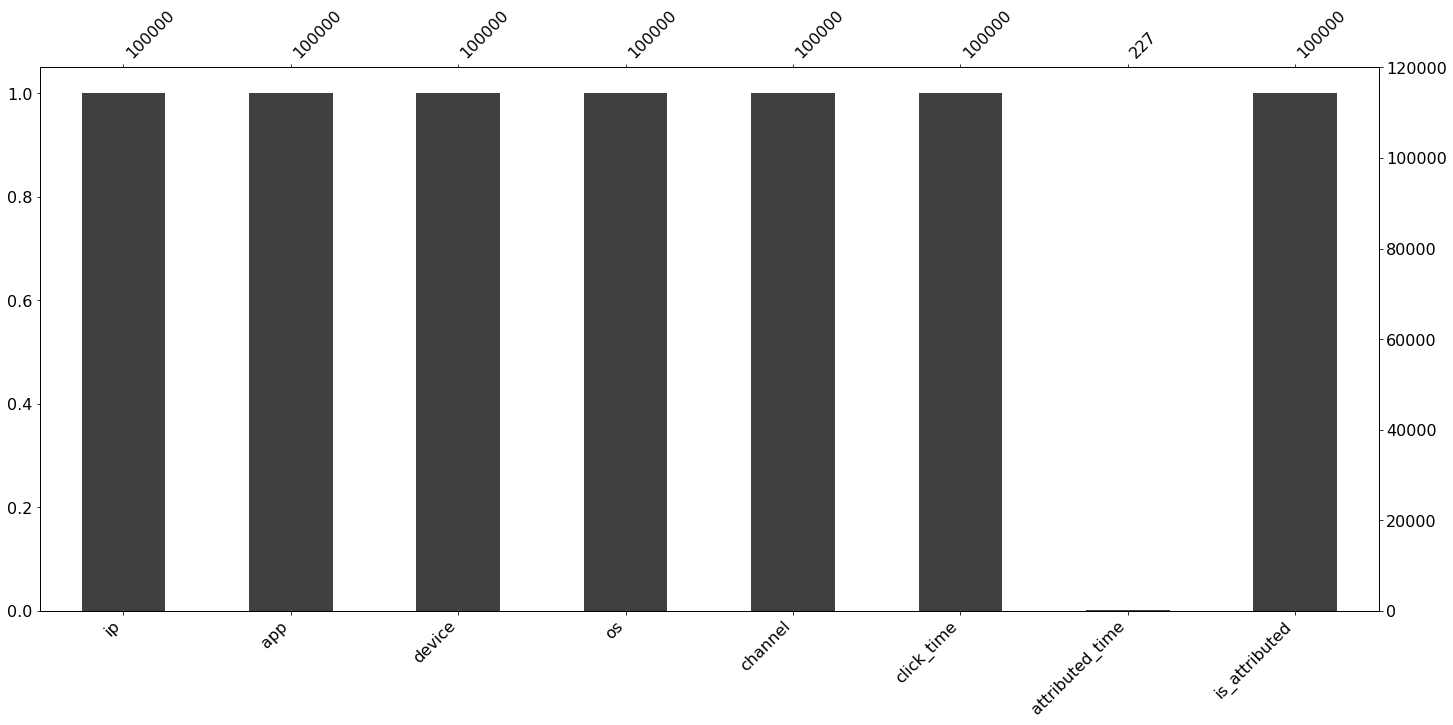

In [7]:
msno.bar(df_train)

In [8]:
(1-(227/100000))*100

99.773

The `train_sample.csv` contains 100,000 randomly-selected rows from the training data. `attributed_time` is the only column with missing data. In the `train_sample.csv` dataset, 99.773% of the data was missing! `attributed_time` represents the time of the app download, after the user clicked on the ad. 
Hypothesis: Could this imply that in 99.773% of transactions, the app was not downloaded? 
Result: Yes. Only 227 of 100,000 transactions had 1's; indicating that the app was downloaded. This is certainly a class imbalance problem!

In [9]:
df_train["is_attributed"].value_counts()

0    99773
1      227
Name: is_attributed, dtype: int64

# Univariate Analysis

In [13]:
for var_col in df_train.columns:
    print("Total number of " + var_col + " addresses: ", df_train[var_col].count())
    print("Total number of UNIQUE " + var_col + " addresses: ", len(df_train[var_col].unique()))
    print()

Total number of ip addresses:  100000
Total number of UNIQUE ip addresses:  34857

Total number of app addresses:  100000
Total number of UNIQUE app addresses:  161

Total number of device addresses:  100000
Total number of UNIQUE device addresses:  100

Total number of os addresses:  100000
Total number of UNIQUE os addresses:  130

Total number of channel addresses:  100000
Total number of UNIQUE channel addresses:  161

Total number of click_time addresses:  100000
Total number of UNIQUE click_time addresses:  80350

Total number of attributed_time addresses:  227
Total number of UNIQUE attributed_time addresses:  228

Total number of is_attributed addresses:  100000
Total number of UNIQUE is_attributed addresses:  2



In [66]:
df_train.dtypes

ip                  int64
app                 int64
device              int64
os                  int64
channel             int64
click_time         object
attributed_time    object
is_attributed       int64
dtype: object

# Feature Engineering

In [5]:
start_time = time.time()

df_train_features = pd.read_csv("data/train.csv", nrows=1000000)

print("Time taken to load the data: {} ".format(time.time() - start_time))

Time taken to load the data: 0.7329750061035156 


In [6]:
df_train_features.shape

(1000000, 8)

In [7]:
# #For computational purposes only
y = df_train_features['is_attributed']
df_train_features.drop(['is_attributed'], axis=1, inplace=True)

df_train_features.drop(["attributed_time"], axis=1, inplace=True)
gc.collect()

73

In [8]:
start_time = time.time()

# #Feature - Frequency Encoding
df_train_features['ip_freq_encoding'] = df_train_features.groupby('ip')['ip'].transform('count')
df_train_features['app_freq_encoding'] = df_train_features.groupby('app')['app'].transform('count')
df_train_features['device_freq_encoding'] = df_train_features.groupby('device')['device'].transform('count')
df_train_features['os_freq_encoding'] = df_train_features.groupby('os')['os'].transform('count')
df_train_features['channel_freq_encoding'] = df_train_features.groupby('channel')['channel'].transform('count')

print("Time taken for Feature Engineering - Frequency Encoding: {} ".format(time.time() - start_time))

Time taken for Feature Engineering - Frequency Encoding: 0.6361618041992188 


In [9]:
gc.collect()

35

In [10]:
start_time = time.time()

# #Feature - Datetime Extraction
df_train_features["click_time"] = pd.to_datetime(df_train_features["click_time"])

df_train_features["click_time_hour"] = df_train_features["click_time"].dt.hour.astype(int)
df_train_features["click_time_minute"] = df_train_features["click_time"].dt.minute.astype(int)
df_train_features["click_time_dayofweek"] = df_train_features["click_time"].dt.dayofweek.astype(int)
df_train_features["click_time"] = df_train_features["click_time"].dt.day.astype(int)


# df_train_features["attributed_time_day"] = df_train_features["attributed_time"].dt.day.fillna(0).astype(int)
# df_train_features["attributed_time_hour"] = df_train_features["attributed_time"].dt.hour.fillna(0).astype(int)
# df_train_features["attributed_time_minute"] = df_train_features["attributed_time"].dt.minute.fillna(0).astype(int)
# df_train_features["attributed_time_dayofweek"] = df_train_features["attributed_time"].dt.dayofweek.fillna(0).astype(int)

# df_train_features["attributed_click_diff"] = ((df_train_features["attributed_time"] - df_train_features["click_time"])/np.timedelta64(1, 'm'))

# df_train_features.drop(["click_time"], axis=1, inplace=True)

print("Time taken for Feature Engineering - Datetime Extraction: {} ".format(time.time() - start_time))

Time taken for Feature Engineering - Datetime Extraction: 0.5036845207214355 


In [11]:
gc.collect()

21

In [12]:
start_time = time.time()

# #Feature - Combine device and os
df_train_features['device_os'] = df_train_features['device'].astype(str) + "_" +df_train_features['os'].astype(str)
df_train_features["device_os"] = df_train_features["device_os"].astype('category').cat.codes

print("Time taken for Feature Engineering - Combine device and os: {} ".format(time.time() - start_time))

Time taken for Feature Engineering - Combine device and os: 1.3266551494598389 


In [13]:
gc.collect()

14

In [14]:
start_time = time.time()

# #Feature - Rank Transformation
df_train_features['ip_rank'] = df_train_features['ip_freq_encoding'].rank(method='dense')
df_train_features['app_rank'] = df_train_features['app_freq_encoding'].rank(method='dense')
df_train_features['device_rank'] = df_train_features['device_freq_encoding'].rank(method='dense')
df_train_features['os_rank'] = df_train_features['os_freq_encoding'].rank(method='dense')
df_train_features['channel_rank'] = df_train_features['channel_freq_encoding'].rank(method='dense')

print("Time taken for Feature Engineering - Rank Transformation: {} ".format(time.time() - start_time))

Time taken for Feature Engineering - Rank Transformation: 0.44304656982421875 


In [15]:
gc.collect()

35

In [16]:
# df_train_features.to_csv("data/train_features_extracted.csv")

In [17]:
gc.collect()

0

# Model Building

In [18]:
# #Prepare the Train Dataset
# y = df_train_features['is_attributed']
# df_train_features.drop(['is_attributed'], axis=1, inplace=True)
# df_train_features = df_train_features.loc[:, df_train_features.columns != "is_attributed"]

In [19]:
gc.collect()

0

In [20]:
# #Prepare the Test Dataset
df_test = pd.read_csv("data/test.csv")

submission = pd.DataFrame()
submission['click_id'] = df_test['click_id']
df_test.drop('click_id', axis=1, inplace=True)
# df_test = df_test.loc[:, df_test.columns != "click_id"]

In [21]:
gc.collect()

28

## Model 1 - XGBoost

In [22]:
# df_train_features.dtypes

In [23]:
start_time = time.time()

params = {'eta': 0.1, 
          'max_depth': 4, 
          'subsample': 0.9, 
          'colsample_bytree': 0.7, 
          'colsample_bylevel':0.7,
          'min_child_weight':100,
          'alpha':4,
          'objective': 'binary:logistic', 
          'eval_metric': 'auc', 
          'random_state': 99, 
          'silent': True}
          
x1, x2, y1, y2 = train_test_split(df_train_features, y, test_size=0.2, random_state=42)

gc.collect()

watchlist = [(xgb.DMatrix(x1, y1), 'train'), (xgb.DMatrix(x2, y2), 'valid')]
model = xgb.train(params, xgb.DMatrix(x1, y1), 270, watchlist, maximize=True, verbose_eval=100)

print("Time taken for XGBoost Training: {} ".format(time.time() - start_time))

[0]	train-auc:0.789024	valid-auc:0.753456
[100]	train-auc:0.950814	valid-auc:0.92158
[200]	train-auc:0.955841	valid-auc:0.926929
[269]	train-auc:0.958167	valid-auc:0.927755
Time taken for XGBoost Training: 84.22182536125183 


In [24]:
gc.collect()

21

In [25]:
start_time = time.time()

# #Feature - Frequency Encoding
df_test['ip_freq_encoding'] = df_test.groupby('ip')['ip'].transform('count')
df_test['app_freq_encoding'] = df_test.groupby('app')['app'].transform('count')
df_test['device_freq_encoding'] = df_test.groupby('device')['device'].transform('count')
df_test['os_freq_encoding'] = df_test.groupby('os')['os'].transform('count')
df_test['channel_freq_encoding'] = df_test.groupby('channel')['channel'].transform('count')

print("Time taken for Feature Engineering - Frequency Encoding: {} ".format(time.time() - start_time))
gc.collect()

start_time = time.time()

# #Feature - Combine device and os
df_test['device_os'] = df_test['device'].astype(str) + "_" +df_test['os'].astype(str)
df_test["device_os"] = df_test["device_os"].astype('category').cat.codes

print("Time taken for Feature Engineering - Combine device and os: {} ".format(time.time() - start_time))
gc.collect()

start_time = time.time()

# #Feature - Rank Transformation
df_test['ip_rank'] = df_test['ip_freq_encoding'].rank(method='dense')
df_test['app_rank'] = df_test['app_freq_encoding'].rank(method='dense')
df_test['device_rank'] = df_test['device_freq_encoding'].rank(method='dense')
df_test['os_rank'] = df_test['os_freq_encoding'].rank(method='dense')
df_test['channel_rank'] = df_test['channel_freq_encoding'].rank(method='dense')

print("Time taken for Feature Engineering - Rank Transformation: {} ".format(time.time() - start_time))
gc.collect()

start_time = time.time()

# #Feature - Convert to Datetime
df_test["click_time"] = pd.to_datetime(df_test["click_time"])

print("Time taken for Feature Engineering - Convert to Datetime: {} ".format(time.time() - start_time))
gc.collect()

start_time = time.time()

# #Feature - Datetime Extraction

df_test["click_time_hour"] = df_test["click_time"].dt.hour.astype(int)
df_test["click_time_minute"] = df_test["click_time"].dt.minute.astype(int)
df_test["click_time_dayofweek"] = df_test["click_time"].dt.dayofweek.astype(int)
df_test["click_time"] = df_test["click_time"].dt.day.astype(int)

print("Time taken for Feature Engineering - Datetime Extraction: {} ".format(time.time() - start_time))

MemoryError: 

In [ ]:
submission['is_attributed'] = model.predict(xgb.DMatrix(df_test), ntree_limit=model.best_ntree_limit)
submission.to_csv('model_1_xbg_submission.csv',index=False)

In [ ]:
gc.collect()